In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import res.process_data.dire_and_coor as dc
from res.wgan.genetator import Generator
from res.wgan.critic import Critic
import res.process_data.process_raw_data as prd
from res.process_data.dataset import tensor_dataset
from res.wgan.functions import get_noise
from res.process_data import test_nn
import res.process_data.process_output as out
from res.wgan.training import Training

ModuleNotFoundError: No module named 'functions'

In [2]:
# prepare the raw data
coordinates_input = prd.read_coordinate(16, "Coordinates.dat")
directions_input = dc.coor_direction_four(coordinates_input)

In [3]:
n_epochs = 20
z_dim = 8
display_step = 50
batch_size = 128
lr = 0.0003
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cpu'
shuffle = True
num_worker = 4
pin_memory = True

In [ ]:
input_tensor = torch.Tensor(directions_input)
dataset = tensor_dataset(input_tensor, 15, 1)
dataloader = DataLoader(dataset= dataset,
                            shuffle=shuffle,
                            batch_size=batch_size,
                            num_workers=num_worker,
                            pin_memory=pin_memory)

In [35]:
gen = Generator(z_dim, im_dim=15, hidden_dim=16).to(device)
crit = Critic(im_dim=15, hidden_dim=16).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

In [36]:
# check the output of generator before training
before_training = test_nn.check_output(gen, 100, 16, 8, 15)
sns.histplot(data=before_training, kde=True)

Train model

In [5]:
Training(n_epochs, dataloader, device, crit_repeats, gen, gen_opt,
             crit, crit_opt, z_dim, c_lambda, display_step)

  0%|          | 0/782 [00:00<?, ?it/s]

Step 50: Generator loss: -1.9967911380529404, critic loss: 5.058039585113525
Step 100: Generator loss: -1.7831411826610566, critic loss: 6.127570647239686
Step 150: Generator loss: -2.3487829422950743, critic loss: 6.478100473403931
Step 200: Generator loss: -3.554502420425415, critic loss: 6.009412979125976
Step 250: Generator loss: -5.009532518386841, critic loss: 5.855951089859008
Step 300: Generator loss: -5.667220258712769, critic loss: 5.833225620269776
Step 350: Generator loss: -5.719594345092774, critic loss: 5.918779788970946
Step 400: Generator loss: -5.871030416488647, critic loss: 5.9281408500671375
Step 450: Generator loss: -6.017102937698365, critic loss: 5.917574058532715
Step 500: Generator loss: -6.033053436279297, critic loss: 5.951829582214355
Step 550: Generator loss: -6.1098432445526125, critic loss: 5.920103181838989
Step 600: Generator loss: -6.117670497894287, critic loss: 5.906815475463869
Step 650: Generator loss: -6.15238471031189, critic loss: 5.891805131912

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

### main steps to process output data
1. sava the parameters and load them into new one.
2. get some output data.
3. get the number of back folding, crossing, and self-avoiding.
4. get the sub-array contains self-avoiding.
5. get the string representing self-avoiding polymer.
6. remove the duplicate from itself and check the different number.
7. check the overlap with raw data.
8. check some statistic value

save and load mode

In [ ]:
# save the model
# torch.save({'gen_state_dict': gen.state_dict()}, 'wgan_gen_scalar.pth.tar')
# torch.save({'crit_state_dict': crit.state_dict()}, 'wgan_crit_scalar.pth.tar')

In [4]:
# load the model
# create a new model, same structure as the previous one
gen_model = Generator(z_dim, im_dim=15, hidden_dim=16).to(device)
crit_model = Critic(im_dim=15, hidden_dim=16).to(device)
# get the state from stored file
gen_checkpoint = torch.load('wgan_gen_scalar.pth.tar')
crit_chechpoint = torch.load('wgan_crit_scalar.pth.tar')
# load the state to the new model
gen_model.load_state_dict(gen_checkpoint['gen_state_dict'])
crit_model.load_state_dict(crit_chechpoint['crit_state_dict'])

<All keys matched successfully>

get output data

In [5]:
coordinate_output = np.zeros([16000, 16, 2])
# direction_round = np.zeros([16000, 15, 1])
for i in range(1000):
    noise = get_noise(16, 8)
    output = gen_model(noise).data.numpy()
    for j in range(16):
        direction = out.slicing_output(output[j], "direction")
        direction_round = out.round_direction_four(direction)
        coordinate = out.four_direction_to_coordinates(direction_round)
        coordinate_output[(i * 16) + j] = coordinate

count the back folding and corss

In [7]:
folding_count, crossing_count, self_avoid = out.count_fold_cross(coordinate_output)
print (folding_count, crossing_count, self_avoid)
print (folding_count/16000, crossing_count/16000, self_avoid/16000)

5174 611 10673
0.323375 0.0381875 0.6670625


get the sub-array contains self-avoiding.

In [8]:
self_avoid_output = out.arrange_self_avoid_polymer(coordinate_output, self_avoid)

convert coordinates to three direction, and remove duplicate

In [9]:
direction_three = dc.coordinate_direction_three(self_avoid_output)
removed_duplicated, directions_str = out.remove_duplicated(direction_three)

In [11]:
len(removed_duplicated)

65

check overlap with raw data

In [10]:
direction_three_input = dc.coordinate_direction_three(coordinates_input)
input_removed_dupicated_str, input_direction_str = out.remove_duplicated(direction_three_input)
from tqdm.auto import tqdm
repeat = 0
for output in tqdm(removed_duplicated):
    if output in input_removed_dupicated_str:
        repeat += 1
repeat

  0%|          | 0/65 [00:00<?, ?it/s]

5

get the statistic values

In [12]:
distance_array = np.zeros(16000)
for i in range(16000):
    distance_array[i]= out.n_n_distance(coordinate_output[i])
out.statistics(distance_array)

(10.71309150225991, 2.136859954280216, 4.566170464206447)

<AxesSubplot:ylabel='Count'>

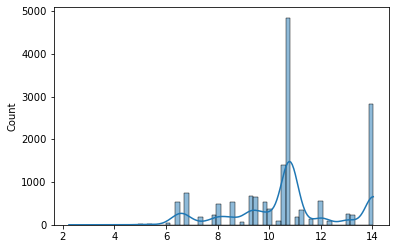

In [13]:
sns.histplot(data=distance_array, kde=True)


In [14]:
output_list = []
for i in range(1000):
    noise = get_noise(16, 8)
    output = gen_model(noise).data.numpy()
    output_list.append(output)

In [29]:
output_list = []
for k in range(100):
    noise = get_noise(16, 8)
    output = gen_model(noise).data.numpy()
    for i in range(16):
        for j in range(15):
            output_list.append(output[i][j])

In [40]:
# should be 100 * 15 * 16 = 24000
24000 == len(output_list)

True

<AxesSubplot:ylabel='Count'>

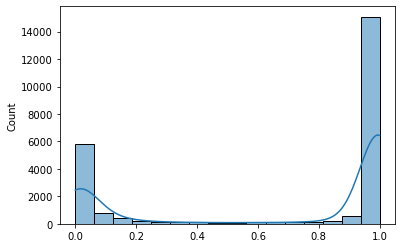

In [31]:
sns.histplot(data=output_list, kde=True)

In [1]:
for i in range(10):
    out.plot_polymer(coordinate_output[i])

NameError: name 'out' is not defined

In [4]:
import pandas as pd
data = pd.DataFrame()
data['number of output'] = 1600
data['back folding'] = 500

In [6]:
print(data)

Empty DataFrame
Columns: [number of output, back folding]
Index: []


In [11]:
data = {'back folding': [1600], 'crossing': [100]}
data
df = pd.DataFrame(data)
df

,back folding,crossing
0,1600,100
